In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
sys.path.append('../scripts/')
sys.path.append('../scripts/dataset_generation/')
from pairwise_addition import PairwiseAddition, AdditionDataset
import models
import generation_utils
import tokenizer
import data_utils
import metrics_utils
from utils import get_best_checkpoint
from train_model import get_loaders
from tqdm.auto import tqdm
import itertools
import model_vis

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [6]:
device = torch.device('cuda')

In [7]:
base_path = '../models/addition/baseline/checkpoints/'

In [8]:
checkpoint = get_best_checkpoint(base_path)
# checkpoint = torch.load(base_path)

Loading model at ../models/addition/baseline/checkpoints/5825_0.0000.pt


In [9]:
args = checkpoint['args']

In [10]:
for key in ['train', 'test', 'oos']:
    args['data'][f'{key}_path'] = '../' + args['data'][f'{key}_path']

In [11]:
problem = PairwiseAddition(args)

In [12]:
train_loader, test_loader, oos_loader = get_loaders(problem)

Loading data...


In [13]:
t = problem.get_tokenizer()

In [14]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [15]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(14, 128)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(14, 128)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=128, out_features=128, bias=False)
            (w_k): Linear(in_features=128, out_features=128, bias=False)
            (w_v): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (w_k_pos): Linear(in_features=128, out_features=128, bias=False)
          )
          (linear1): Linear(in_features=128

In [16]:
np.sum([np.prod(p.size()) for p in model.parameters()])

1209230

  0%|          | 0/6618 [00:00<?, ?it/s]

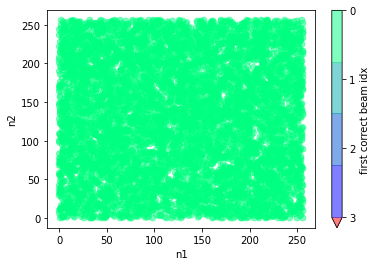

  0%|          | 0/26 [00:00<?, ?it/s]

In [19]:
test_df, test_metrics = problem.compute_metrics(model, device, test_loader, save=False, n_beams=5, max_num=-1)

In [20]:
test_df

,n1,n2,n1 + n2,input_list,label_list,input_str,label_str,pred_tokens,pred_num,log_prob,beam_idx,pred_is_right
0,0,6,6,"[[SOS], 0, +, 6, [EOS]]","[[SOS], 6, [EOS]]",[SOS]0+6[EOS],[SOS]6[EOS],"[13, 6, 12, 11]",6.0,-0.000278,0,True
1,0,6,6,"[[SOS], 0, +, 6, [EOS]]","[[SOS], 6, [EOS]]",[SOS]0+6[EOS],[SOS]6[EOS],"[13, 7, 12, 11]",7.0,-9.082878,1,False
2,0,6,6,"[[SOS], 0, +, 6, [EOS]]","[[SOS], 6, [EOS]]",[SOS]0+6[EOS],[SOS]6[EOS],"[13, 6, 12, 0]",6.0,-9.210619,2,True
3,0,6,6,"[[SOS], 0, +, 6, [EOS]]","[[SOS], 6, [EOS]]",[SOS]0+6[EOS],[SOS]6[EOS],"[13, 6, 12, 1]",6.0,-9.210619,3,True
4,0,6,6,"[[SOS], 0, +, 6, [EOS]]","[[SOS], 6, [EOS]]",[SOS]0+6[EOS],[SOS]6[EOS],"[13, 6, 12, 2]",6.0,-9.210619,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
33085,256,252,508,"[[SOS], 2, 5, 6, +, 2, 5, 2, [EOS]]","[[SOS], 5, 0, 8, [EOS]]",[SOS]256+252[EOS],[SOS]508[EOS],"[13, 5, 0, 8, 12, 11]",508.0,-0.000130,0,True
33086,256,252,508,"[[SOS], 2, 5, 6, +, 2, 5, 2, [EOS]]","[[SOS], 5, 0, 8, [EOS]]",[SOS]256+252[EOS],[SOS]508[EOS],"[13, 5, 0, 8, 12, 0]",508.0,-9.210470,1,True
33087,256,252,508,"[[SOS], 2, 5, 6, +, 2, 5, 2, [EOS]]","[[SOS], 5, 0, 8, [EOS]]",[SOS]256+252[EOS],[SOS]508[EOS],"[13, 5, 0, 8, 12, 1]",508.0,-9.210470,2,True
33088,256,252,508,"[[SOS], 2, 5, 6, +, 2, 5, 2, [EOS]]","[[SOS], 5, 0, 8, [EOS]]",[SOS]256+252[EOS],[SOS]508[EOS],"[13, 5, 0, 8, 12, 2]",508.0,-9.210470,3,True


In [21]:
test_metrics

{'correct_sum': {'pred_is_right': 1.0},
 'first_right_beam': {0: 6618},
 'loss': 2.0461174101528573e-05,
 'meta': {'n_beams': 5, 'temperature': 1.0, 'max_decode_size': 64}}

### Generalization Plot

1599


  0%|          | 0/1599 [00:00<?, ?it/s]

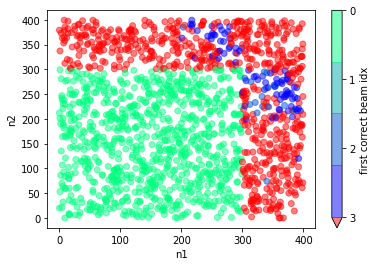

  0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
pairs = np.array(list(itertools.permutations(list(range(400)), 2)))
sample_pct = .01
pairs = pairs[np.random.rand(pairs.shape[0]) < sample_pct]
print(pairs.shape[0])
n_beams = 5

oos_sample_df, oos_sample_metrics = problem.compute_metrics(model, device, problem.get_dataset(pairs), save=False, n_beams=5, max_samples=-1, loader_kwargs = {'batch_size' : 256})

In [24]:
oos_sample_metrics

{'correct_sum': {'pred_is_right': 0.6285178236397748},
 'first_right_beam': {0: 874, -1: 594, 3: 89, 4: 26, 2: 16},
 'loss': 1.263169123712328,
 'meta': {'n_beams': 5, 'temperature': 1.0, 'max_decode_size': 64}}

### Explore the model a little

In [25]:
embeddings = model.src_embedding.embedding.weight.data.cpu().numpy()

In [26]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(problem.special_tokens)
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [27]:
embeddings.shape

(14, 128)

In [28]:
tokens.shape

(14,)

In [29]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '[PAD]',
       '[EOS]', '[SOS]'], dtype='<U11')

In [30]:
from sklearn.manifold import TSNE

In [31]:
tsne = TSNE()
embeddings_for_plot = tsne.fit_transform(embeddings)

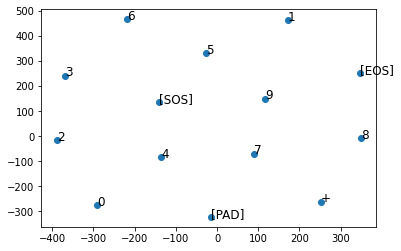

In [32]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    ax.annotate(tok, (x+.3,y), fontsize=12)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

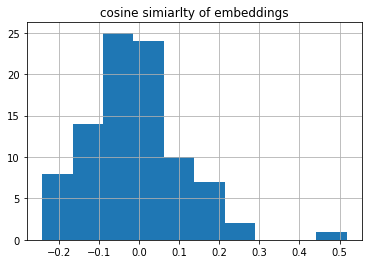

In [35]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

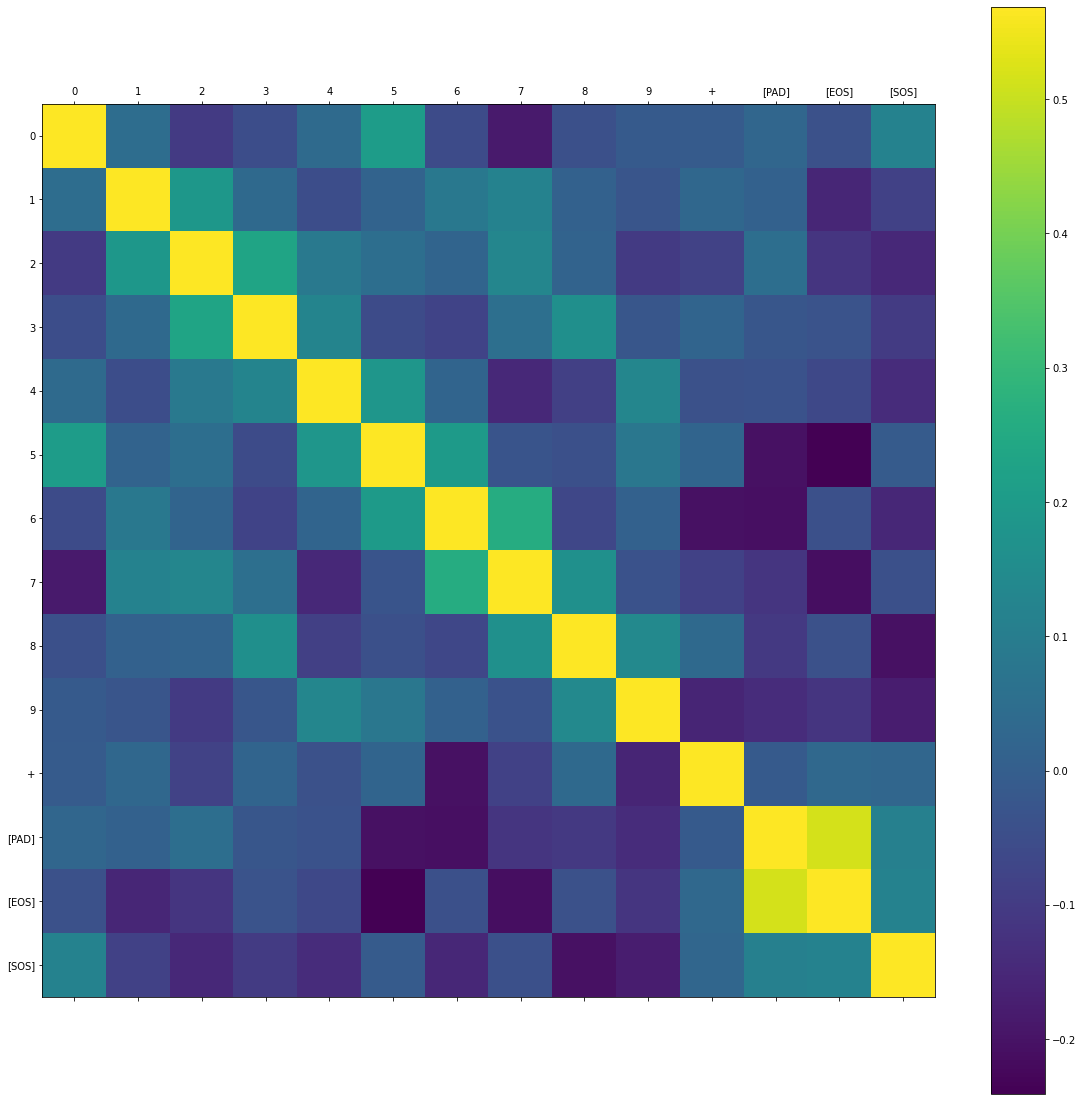

In [36]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

## See what the attention looks at

In [37]:
example_row = problem.form_prediction_df(model, device, problem.get_dataset([[1,1]]), args['model_args']['max_decode_size'], n_beams=1, temperature=1.)

  0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
example_row

,n1,n2,n1 + n2,input_list,label_list,input_str,label_str,pred_tokens,pred_num,log_prob,beam_idx,pred_is_right
0,1,1,2,"[[SOS], 1, +, 1, [EOS]]","[[SOS], 2, [EOS]]",[SOS]1+1[EOS],[SOS]2[EOS],"[13, 2, 12]",2,-0.002301,0,True


In [39]:
input = t.encode(problem.form_input(example_row['n1'].iloc[0], example_row['n2'].iloc[0], args['data']['base']))
# tgt = t.encode(data_utils.dec2base(example_row['pred_num'].iloc[0].replace('_', '').strip().split(' ')))
tgt = t.encode(problem.form_label(example_row['pred_num'].iloc[0], 0, args['data']['base']))

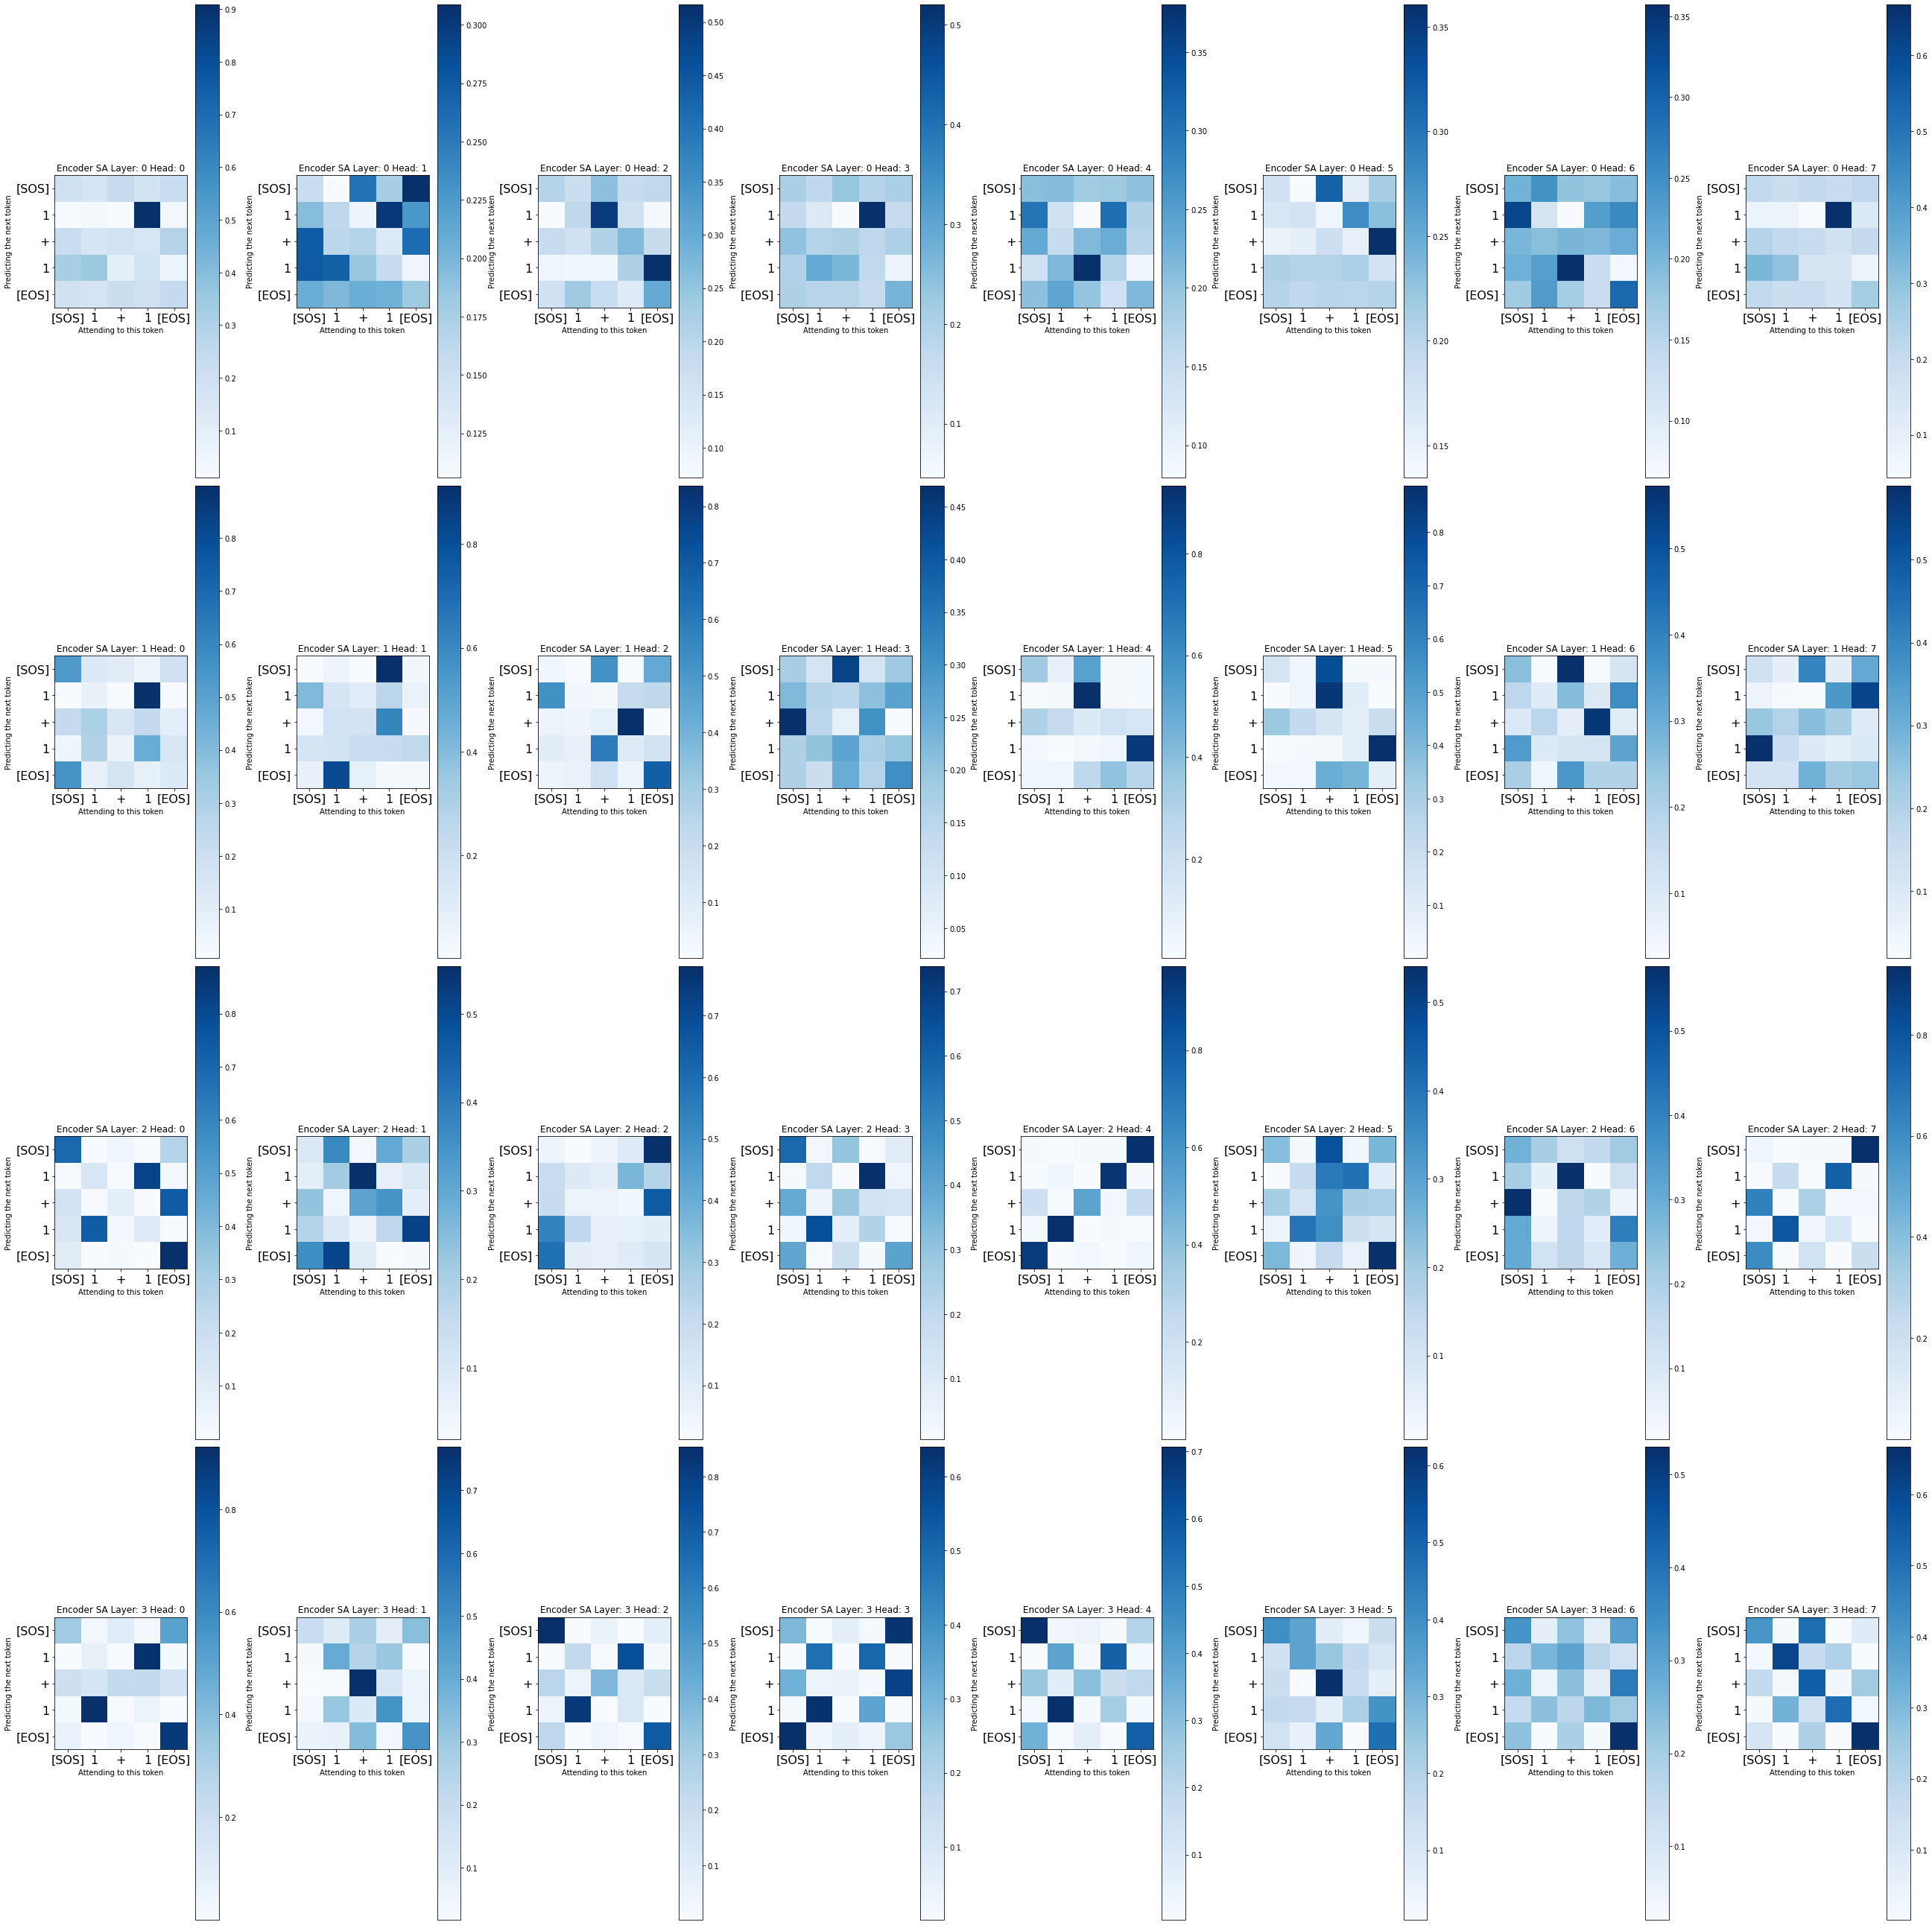

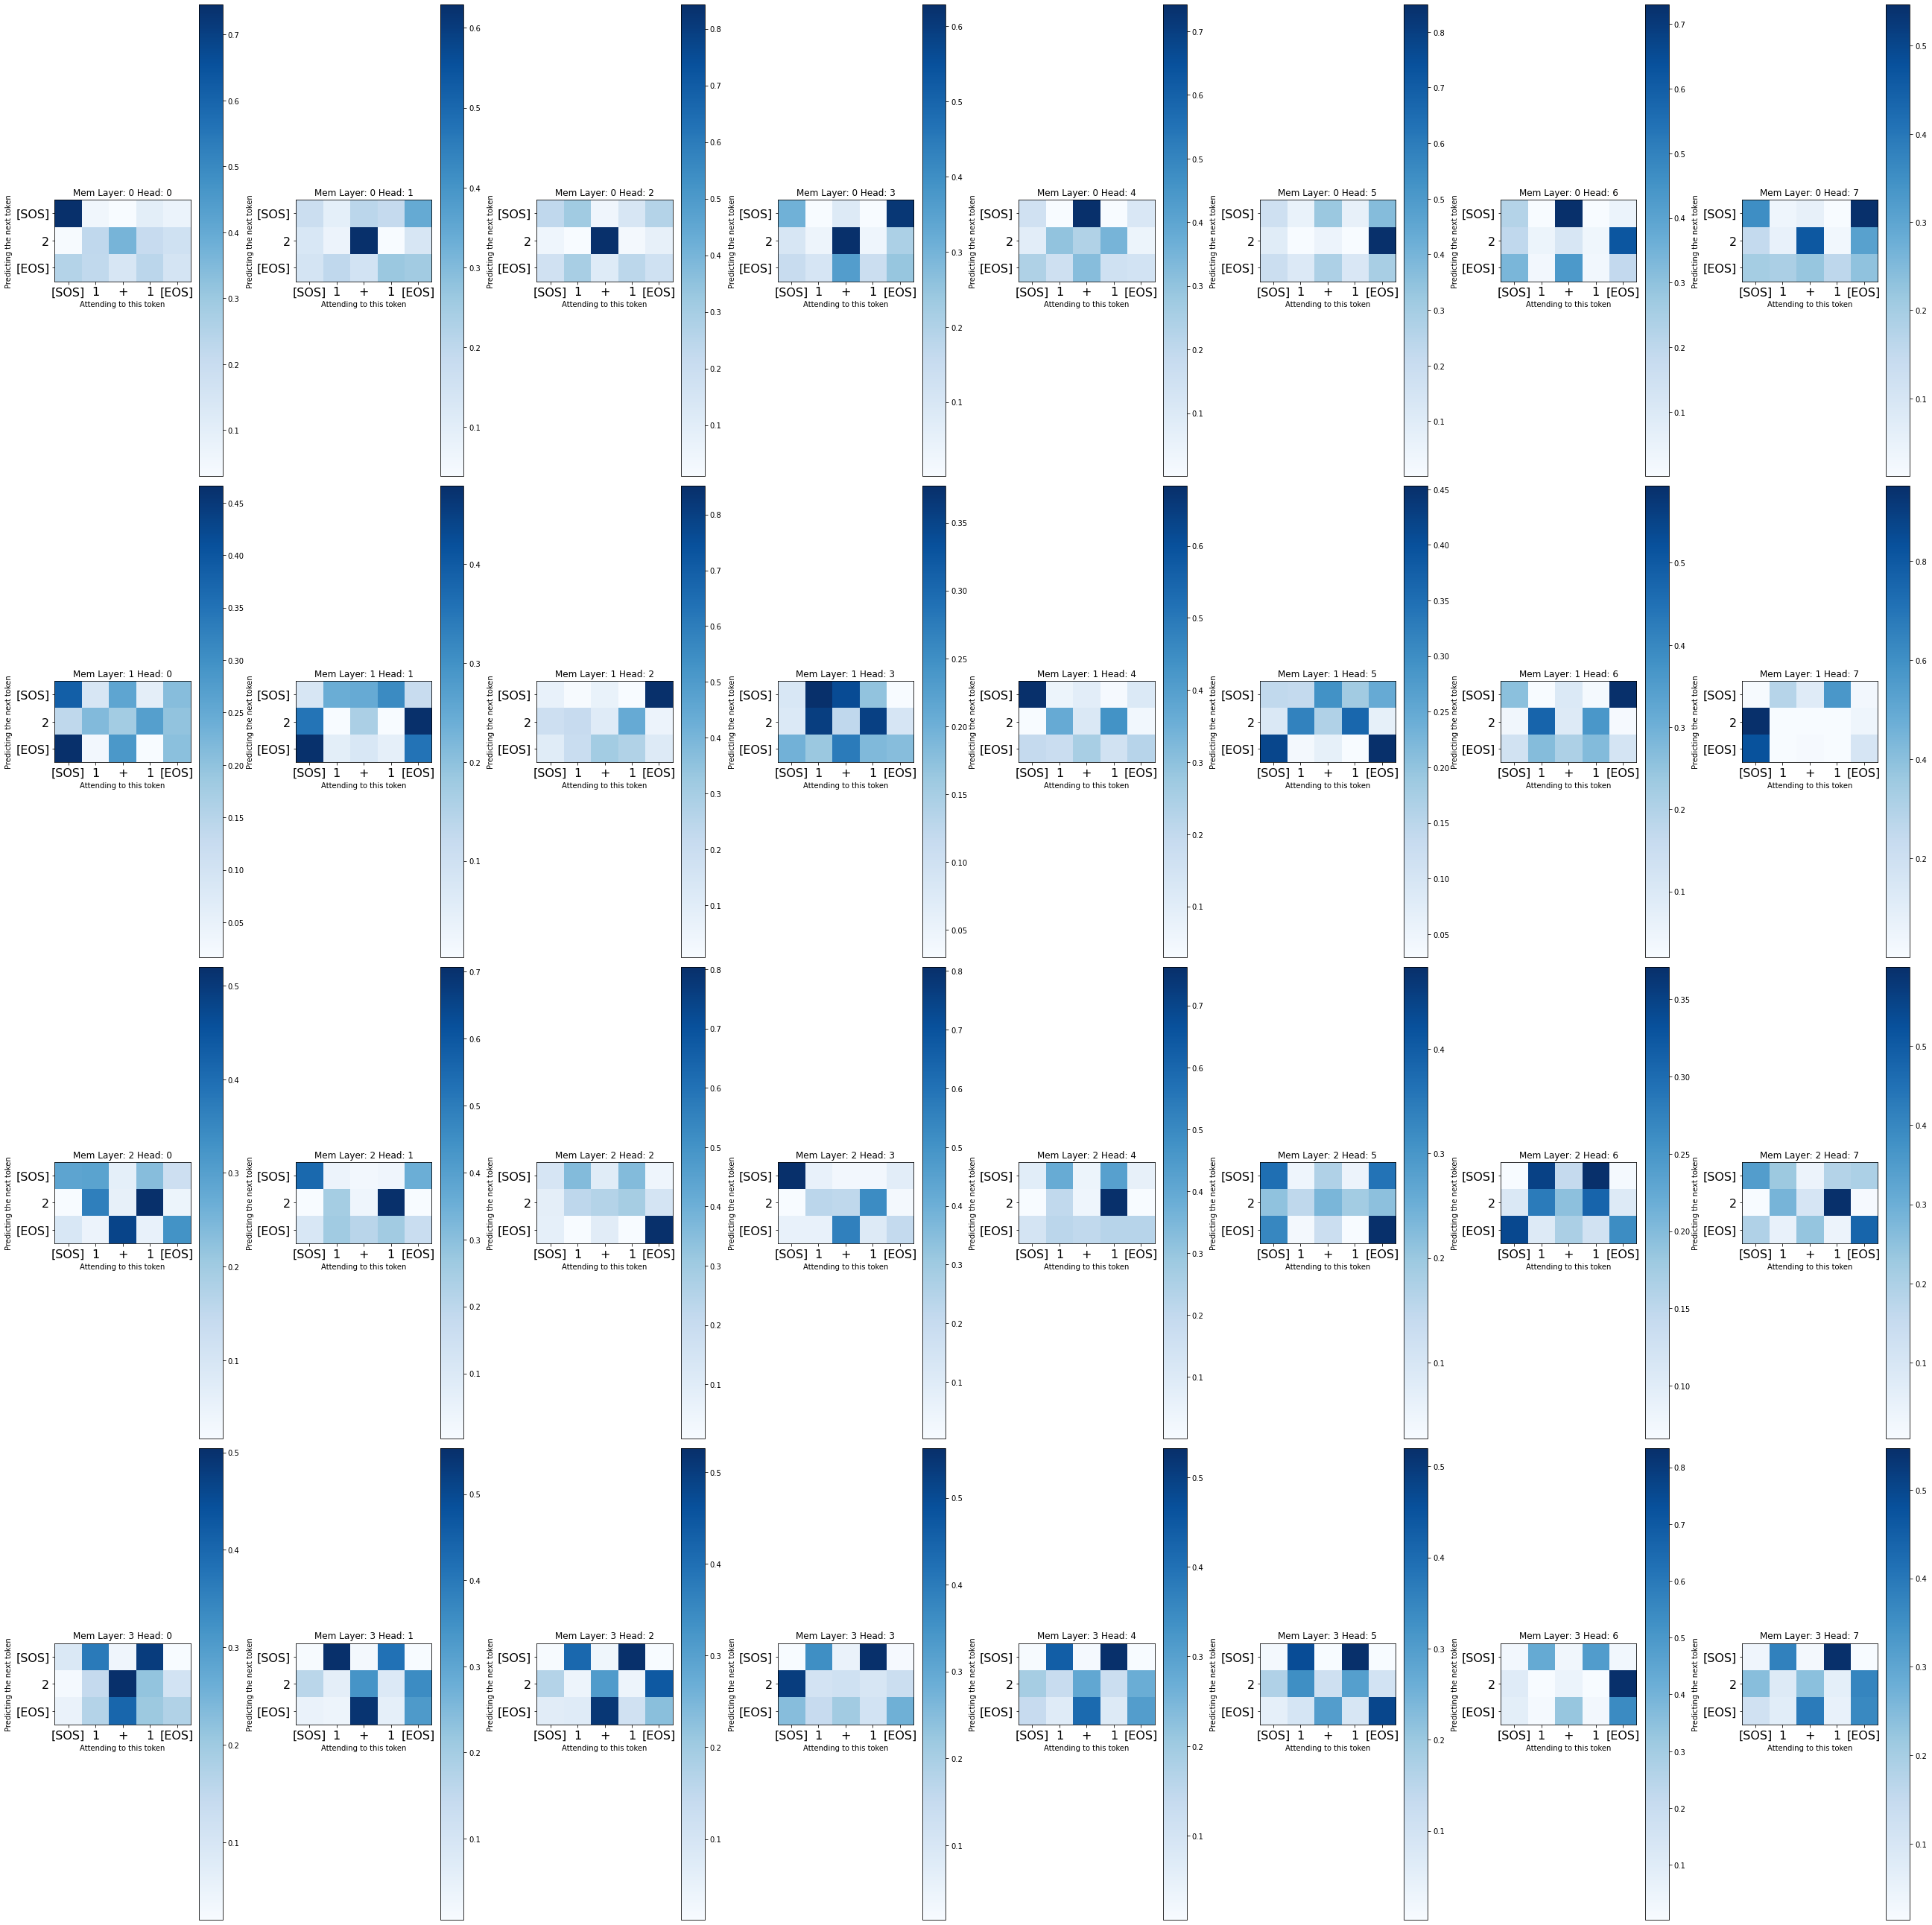

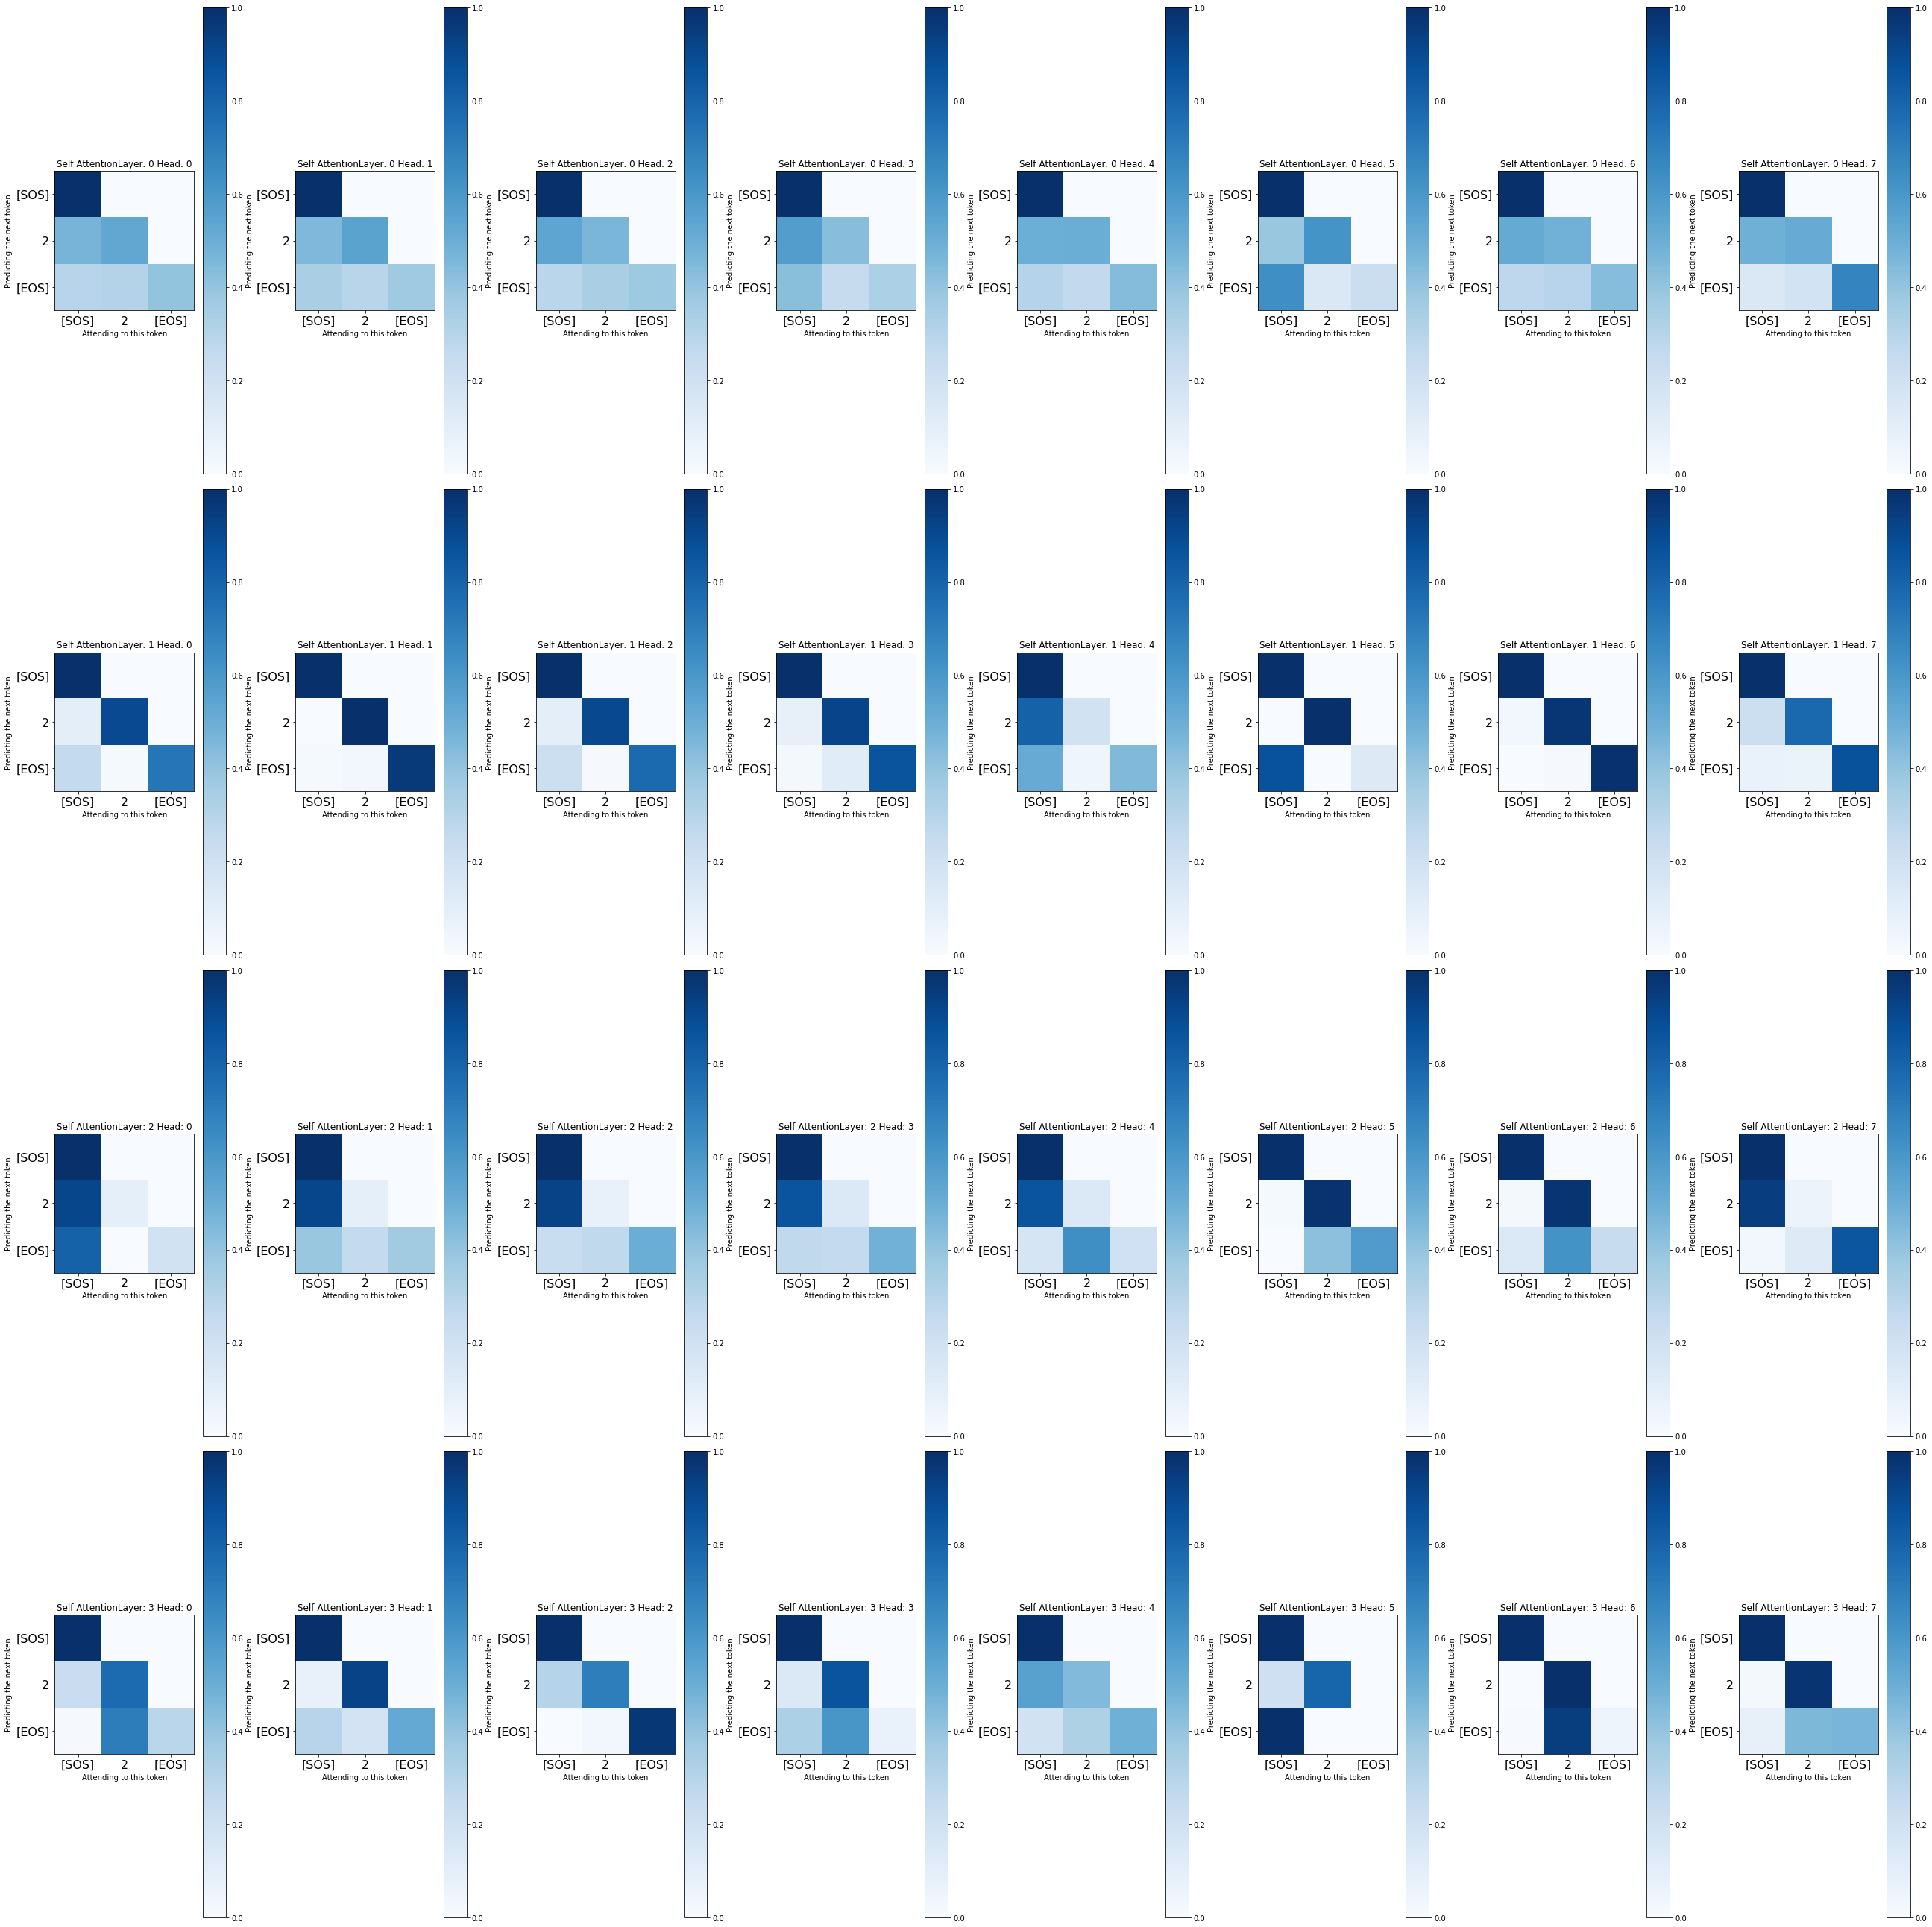

In [40]:
model_vis.visualize_attention(input, tgt, model, t, device)